# Examine final data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import csv

In [14]:
from colour import Color

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.style.use('dark_background')

orange = Color("orange")

color_objs = list(orange.range_to(Color("slateblue"), 14))
colors = [col.hex for col in color_objs]
len(colors)

14

### Import clients

In [3]:
npzfile0 = np.load('./sber_work_files/final/clients_w_gr_names.npz', allow_pickle=True)

client_df = npzfile0['client_df']
group_names = npzfile0['group_names']

### Import news

In [4]:
npzfile1 = np.load('./sber_work_files/final/news4work.npz', allow_pickle=True)

month_ticks = npzfile1['month_ticks']
month_names = npzfile1['month_names']
fin_top_ts = npzfile1['fin_top_ts']
fin_top_names = npzfile1['fin_top_names']
sorted_topic_names_dict = npzfile1['sorted_topic_names_dict']

### Import context

In [5]:
npzfile2 = np.load('./sber_work_files/final/context_w_labels.npz', allow_pickle=True)

context_ts = npzfile2['context_ts']
context_labels = npzfile2['context_labels']

## Plots

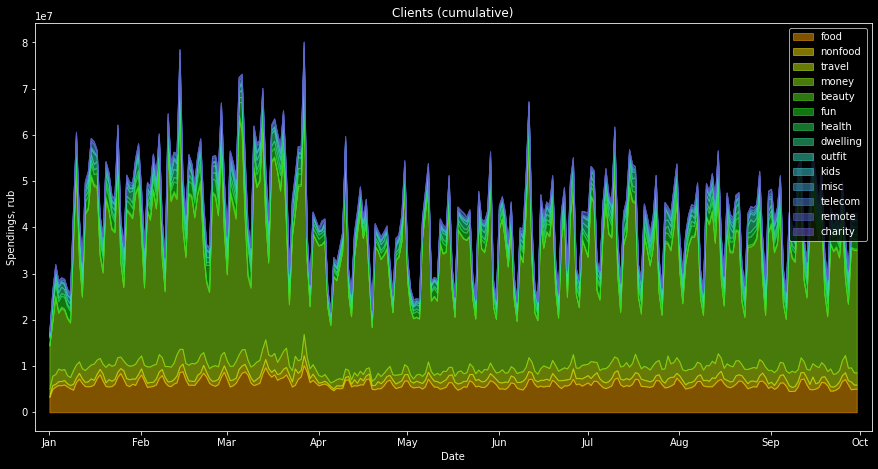

In [6]:
# Cumulative plot for different groups of all clients
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])

x = np.arange(0, client_df.shape[2])
y = np.zeros(x.shape[0])
stack = [client_sum[n][:] for n in range(len(group_names))]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp, y, color=c[i], alpha=0.5)

plt.title("Clients (cumulative)")
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel("Spendings, rub")
plt.xlabel("Date")
plt.legend(tuple(group_names))

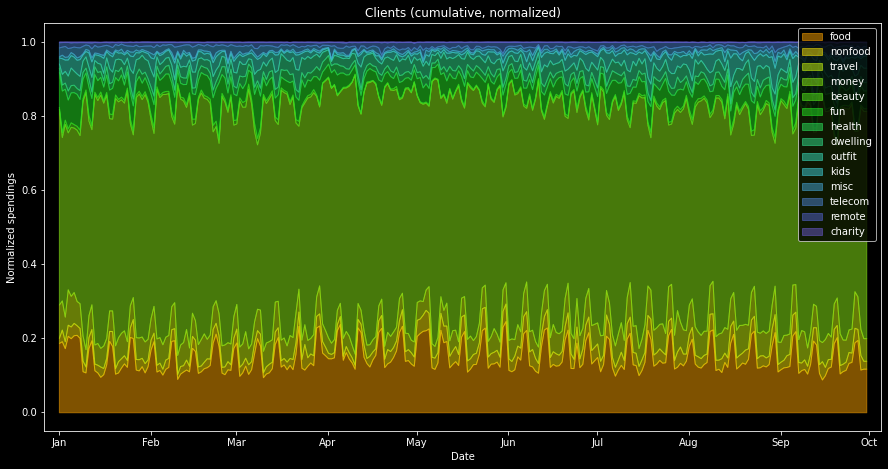

In [7]:
# Normalized cumulative plot for different groups of all clients
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])
mega_sum = client_sum.sum(axis=0).reshape(client_df.shape[2])

x = np.arange(0, client_df.shape[2])
y = np.zeros(x.shape[0])
stack = [client_sum[n][:] for n in range(len(group_names))]

c = colors

for i, item in enumerate(stack):
    yp = np.copy(y)
    y += item
    plt.fill_between(x, yp/mega_sum, y/mega_sum, color=c[i], alpha=0.5)

plt.title("Clients (cumulative, normalized)")
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel("Normalized spendings")
plt.xlabel("Date")
plt.legend(tuple(group_names))

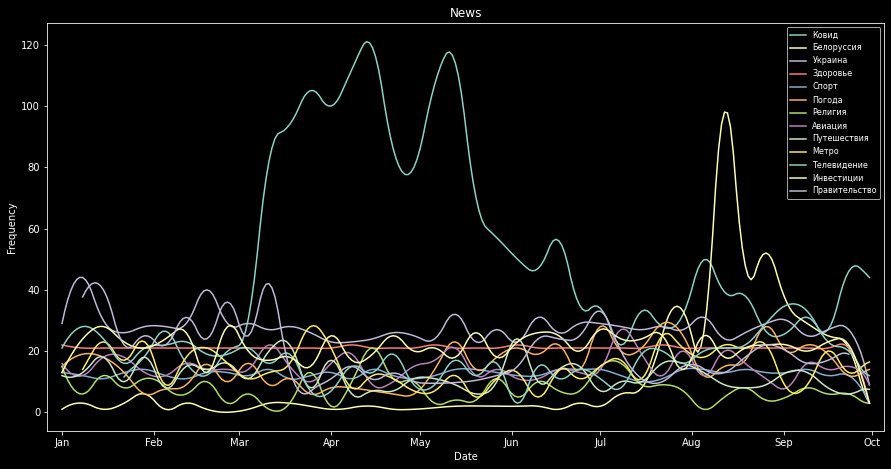

In [8]:
for i in range(fin_top_ts.shape[0]):
    lbl = fin_top_names[i]
    plt.plot(fin_top_ts[i], label=lbl)
    plt.title("News")
    plt.xticks(month_ticks, labels=month_names)
    plt.xlim(-5, 278)
    plt.ylabel("Frequency")
    plt.xlabel("Date")

plt.legend(prop={'size': 8})

Text(0.5, 0, 'Date')

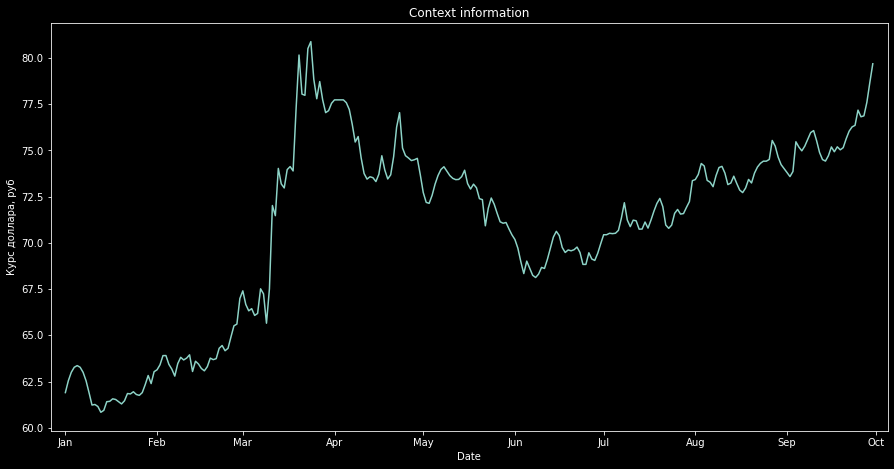

In [9]:
num = 4
plt.plot(context_ts[num])
plt.title("Context information")
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel(context_labels[num])
plt.xlabel("Date")

## Autocorrelation in client dataset

In [10]:
#from influxdb import InfluxDBClient
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

Text(0.5, 0, 'Date')

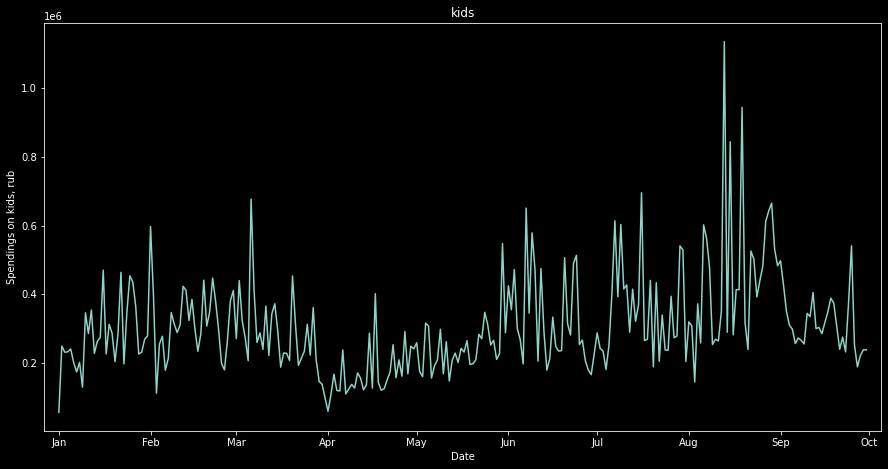

In [11]:
cat = np.random.randint(0, len(group_names))
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])

plt.plot(client_sum[cat])
plt.title(group_names[cat])
plt.xticks(month_ticks, labels=month_names)
plt.xlim(-5, 278)
plt.ylabel(f"Spendings on {group_names[cat]}, rub")
plt.xlabel("Date")

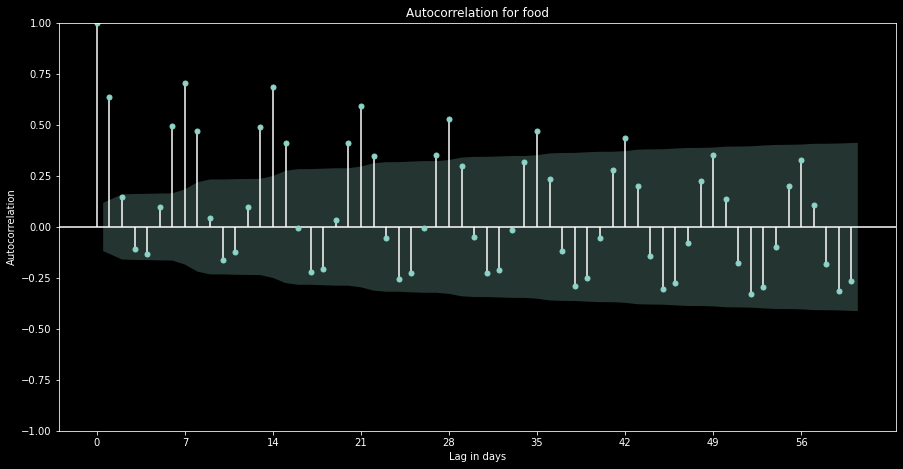

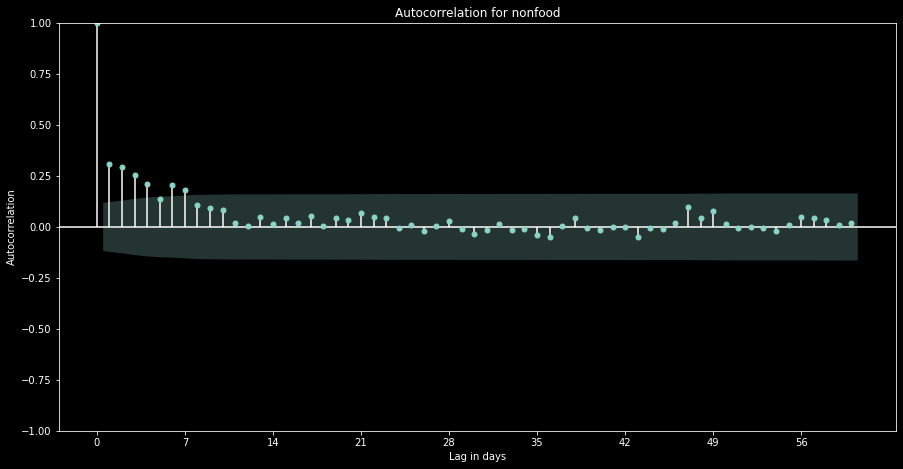

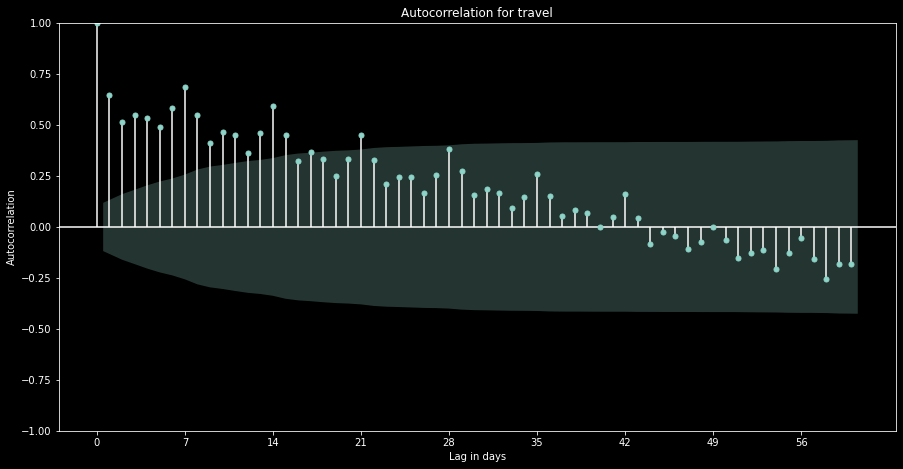

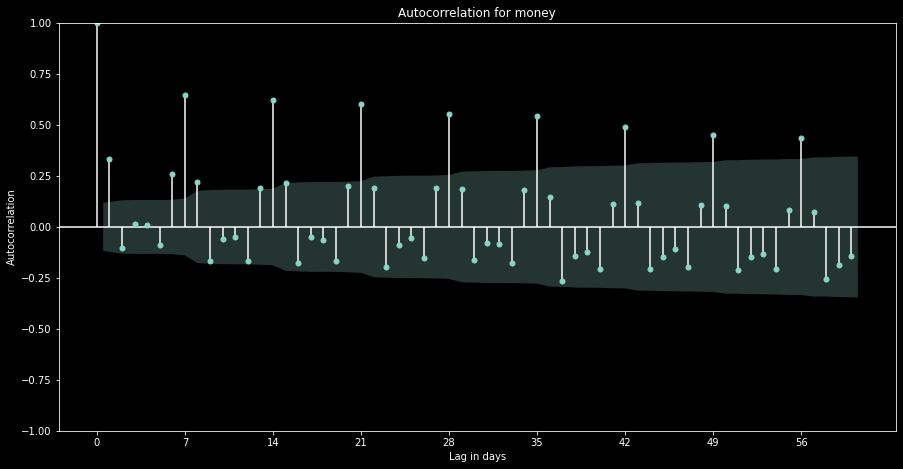

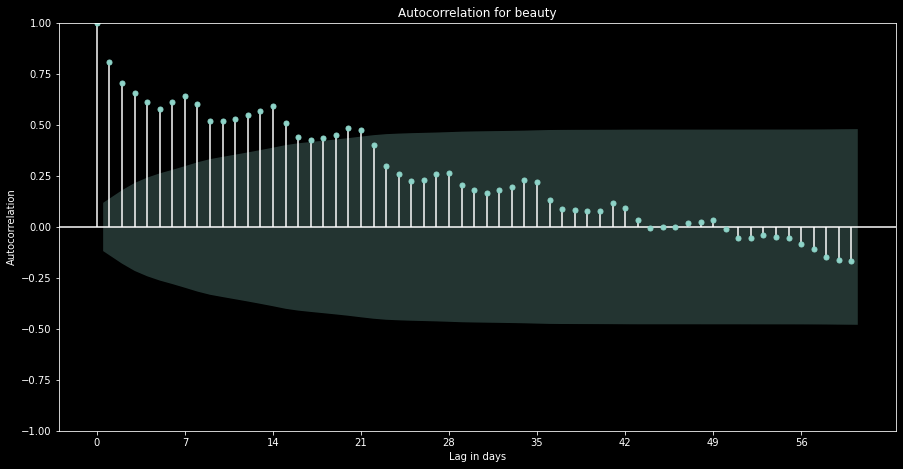

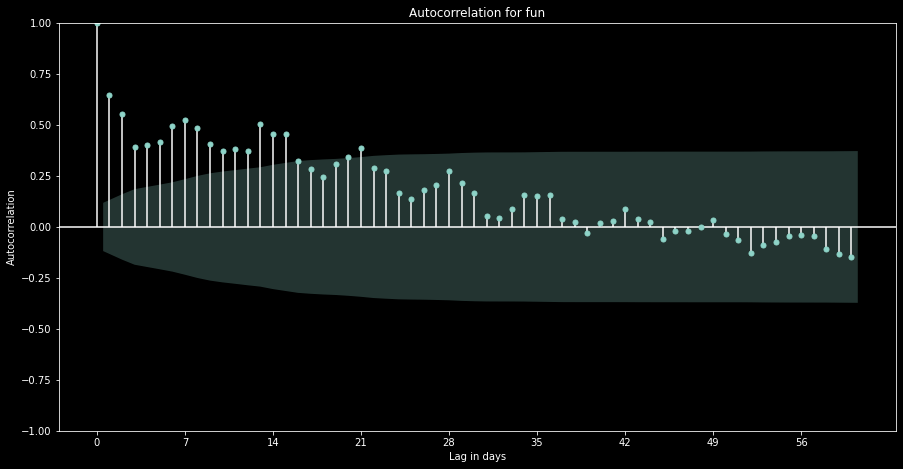

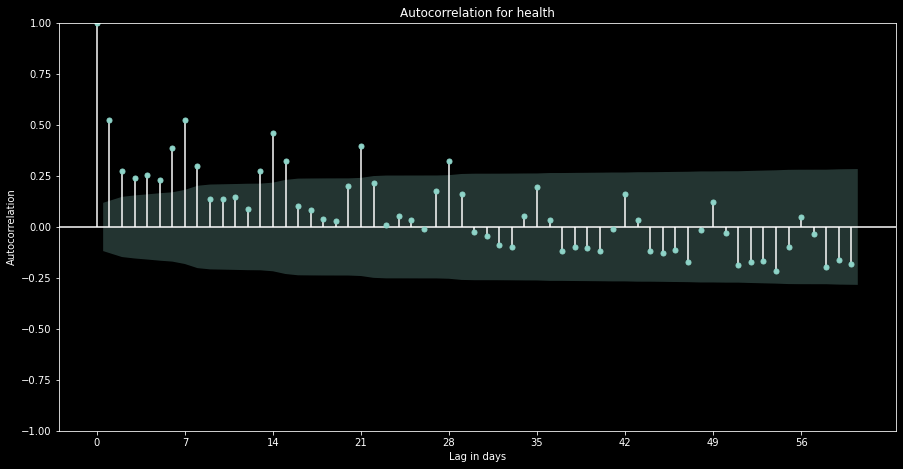

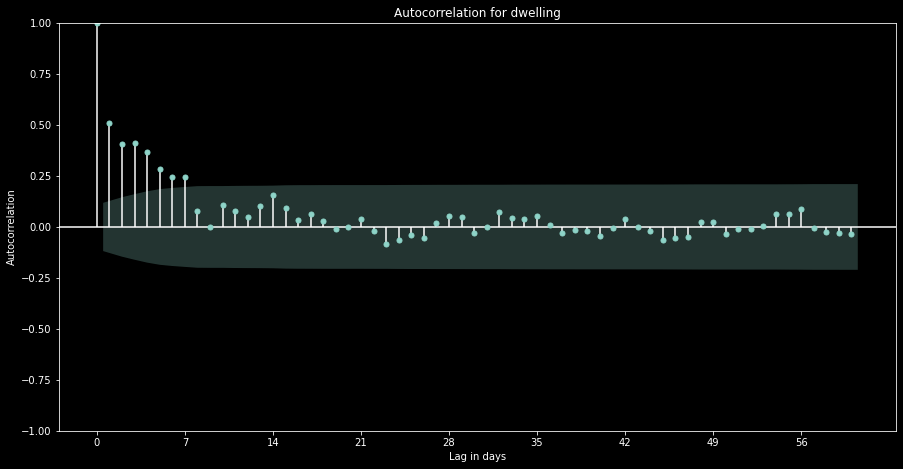

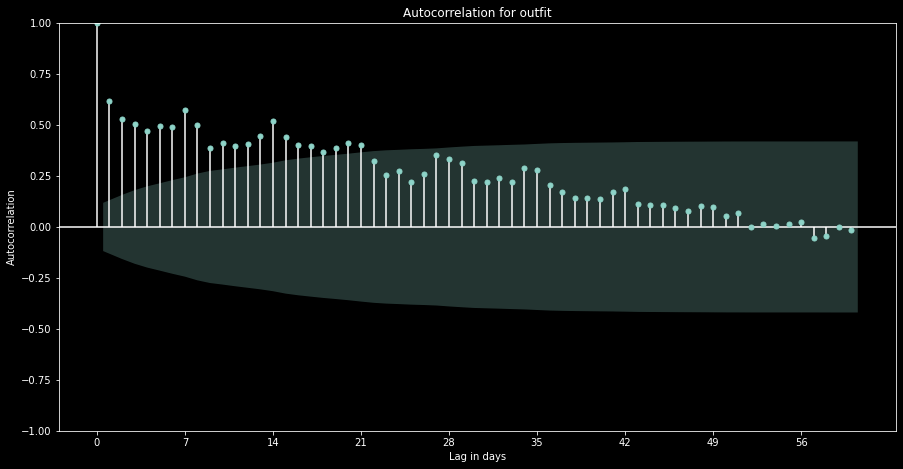

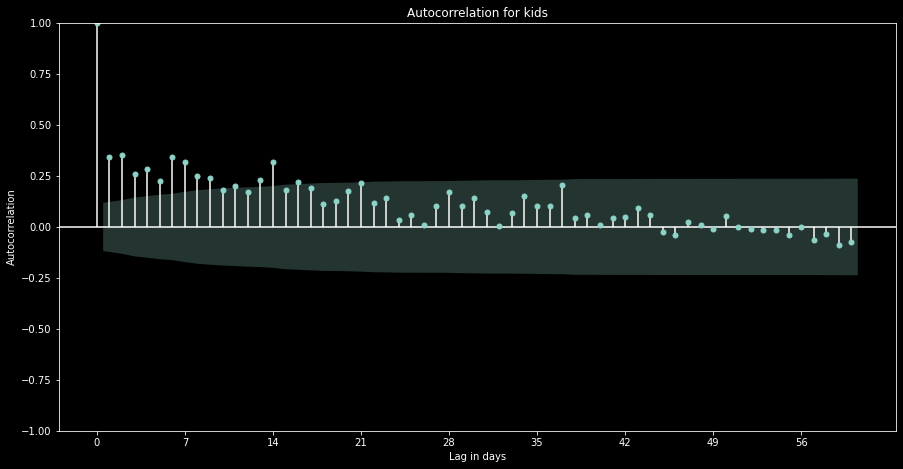

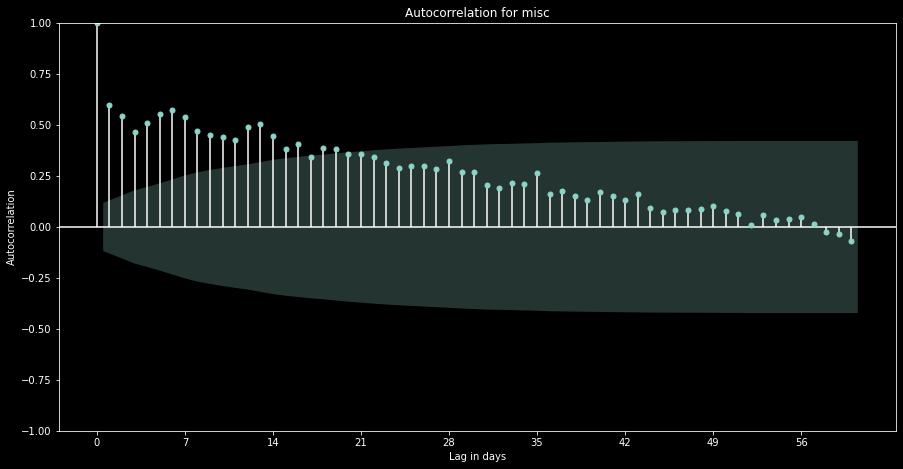

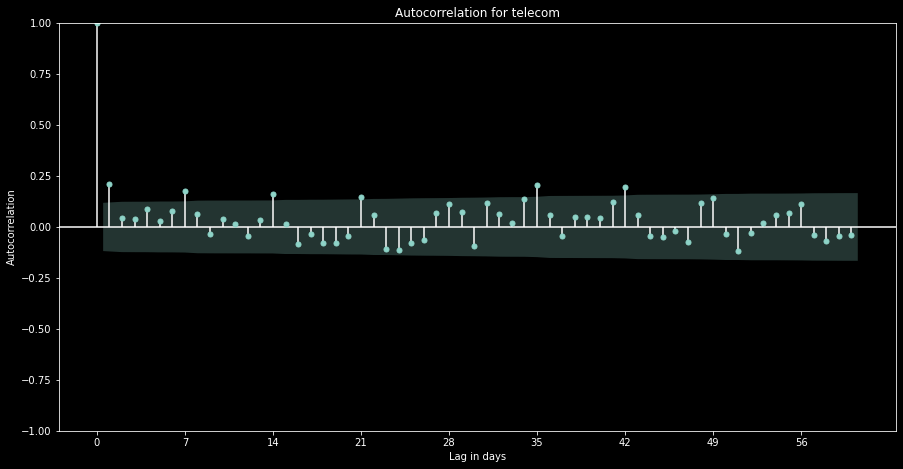

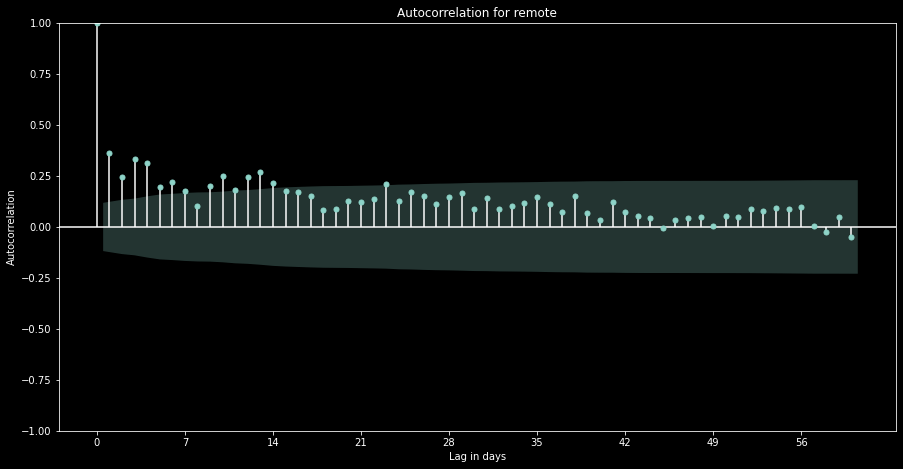

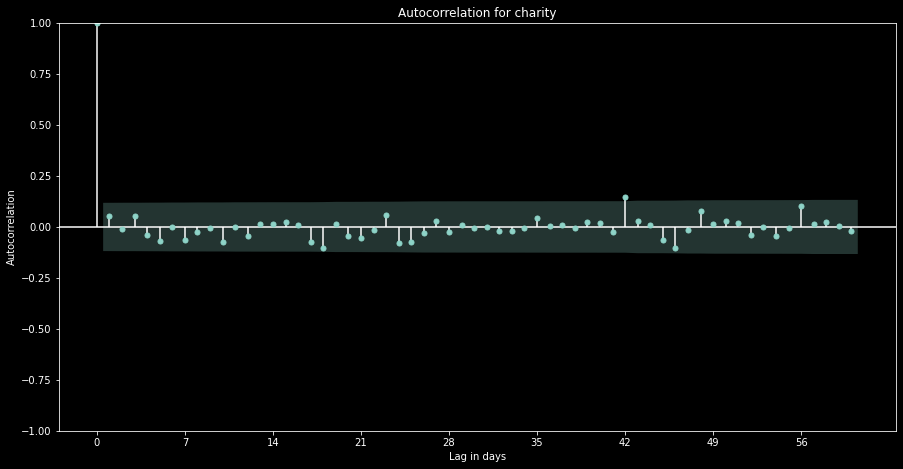

In [18]:
client_sum = client_df.sum(axis=0).reshape(len(group_names), client_df.shape[2])

for i, name in enumerate(group_names):
    num_lags = 60
    plot_acf(client_sum[i], lags=num_lags)
    plt.title(f"Autocorrelation for {name}")
    plt.ylabel("Autocorrelation")
    plt.xlabel("Lag in days")
    plt.xticks(np.arange(0, num_lags, 7))
    plt.show